## __Photonic QCNN architecture__

In this document, we test the photonic QCNN while considering a tensor data loader.

## <mark>Classical Data Loading and Preprocessing</mark>

We load the data from the BAS dataset and we preprocess it:

In [1]:
### Loading the required libraries
import os, sys

sys.path.append(os.path.dirname(os.path.abspath('')))

import warnings
import time
import torch

from Data_Loading.Classical_Data import *


# Hyperparameters:
batch_size = 1
train_dataset_number = 400
test_dataset_number = 200
class_set = [0, 1]
nbr_rows, nbr_cols = 4, 4 

# Pennylane Bars and Stripes dataset:
print('Pennylane Bars and Stripes dataset:')
train_data_loader, test_dataloader = BAS_pennylane_raw_MSE(4, train_dataset_number, test_dataset_number, batch_size)
#train_data_loader, test_dataloader = BAS_pennylane_raw(4, train_dataset_number, test_dataset_number, batch_size)

Pennylane Bars and Stripes dataset:
Train data and label tensors of size:(400, 4, 4) and (400,)
Test data and label tensors of size:(200, 4, 4) and (200,)


We applied a Pooling preprocessing. Let's plot one image we will use:

Corresponding Label: tensor([0, 1])


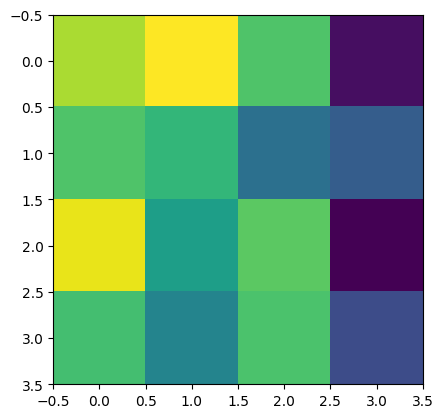

In [2]:
import matplotlib.pyplot as plt

index = 0

plt.figure()
plt.imshow(train_data_loader.dataset.tensors[0][index])
print("Corresponding Label:", train_data_loader.dataset.tensors[1][index])

## <mark>Some details on the quantum data loader:</mark>

In this Section, I will explain how to represent a $4 \times 4$ image of bars or strips __with all the pixels having the same positive value__. Let's take the example of the following input:

In [3]:
print("Checking the train samples")
for sample in range(train_dataset_number):
    if (sum(train_data_loader.dataset.tensors[0][sample].flatten()) == 0):
        print(sample, train_data_loader.dataset.tensors[0][sample])

print("Checking the test samples")
for sample in range(test_dataset_number):
    if (sum(test_dataloader.dataset.tensors[0][sample].flatten()) == 0):
        print(sample, test_dataloader.dataset.tensors[0][sample])

Checking the train samples
Checking the test samples


## <mark>Quantum Convolutional Neural Network</mark>

We define the Quantum Convolutional Neural Network architecture that will be used for the training:

In [4]:
from qoptcraft.basis import get_photon_basis, hilbert_dim
from Layers.Linear_Optics import *
from Layers.measurement import *
from Layers.toolbox_basis_change import Basis_Change_Image_to_Fock_density, Basis_Change_Image_to_larger_Fock_density
from Layers.HW_preserving_QCNN.Conv import Conv_RBS_density_I2
from Layers.HW_preserving_QCNN.Pooling import Pooling_2D_density_HW
from Layers.toolbox import PQNN

### Hyperparameters:
m = nbr_rows + nbr_cols #number of modes in total
add1, add2 = 1, 1
nbr_class = 2
list_gates = [(2,3),(1,2),(3,4),(0,1),(2,3),(4,5),(1,2),(3,4)]
modes_detected = [2,3]

photon_basis = get_photon_basis(m, 2)
dimension = hilbert_dim(m, 2)
print("Hilbert space dimension: ", dimension)

# Define the network:
#criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.MSELoss()
device = torch.device("cpu")


class Photonic_QCNN(nn.Module):
    """ A class defining the fully connected neural network """
    def __init__(self, m, list_gates, modes_detected, device):
        super(Photonic_QCNN, self).__init__()
        self.device = device
        self.Conv = Conv_RBS_density_I2(m//2, 2, device)
        self.Pool = Pooling_2D_density_HW(m//2, m//4, device)
        self.toFock = Basis_Change_Image_to_larger_Fock_density(m//4, m//4, add1, add2, device)
        self.dense = VQC_Fock_BS_density(2, m//2 + add1 + add2, list_gates,device)
        self.measure = Measure_Photon_detection(2, m//2 + add1 + add2, modes_detected, device)
        #self.toFock =  Basis_Change_Image_to_Fock_density(m//4,m//4,device)
        #self.dense = VQC_Fock_BS_density(2, m//2, list_gates,device)
        #self.measure = Measure_Photon_detection(2, m//2, 0, device)
    def forward(self, x):
        x = self.Conv(x)
        x = self.Pool(x)
        return self.measure(self.dense(self.toFock(x)))
       

network_dense = Photonic_QCNN(m,  list_gates, modes_detected, device)

Hilbert space dimension:  36


/Users/leomonbroussou/Documents/GitHub/Photonic_Subspace_QML_Toolkit/Layers/Linear_Optics.py:215: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Copy.cpp:305.)
  HU = torch.tensor(HU, dtype=torch.float32, device=device)


Let's train the neural network:

In [5]:
import torch.nn.functional as F
from torch.optim.lr_scheduler import ExponentialLR
from Training.training import train_globally_MSE

#optimizer = torch.optim.SGD(network_dense.parameters())
optimizer = torch.optim.Adam(network_dense.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = ExponentialLR(optimizer, gamma=0.9)
output_scale, train_epochs, test_interval = 1, 30, 1

network_state, training_loss_list, training_accuracy_list, testing_loss_list, testing_accuracy_list = train_globally_MSE(batch_size, 4, network_dense, train_data_loader, test_dataloader, optimizer, scheduler,
                                  criterion, output_scale, train_epochs, test_interval, device)
torch.save(network_state, "model_state_MSE")  # save network parameters

Start training! Number of network total parameters: 10


/opt/anaconda3/envs/photonic_env/lib/python3.11/site-packages/torch/_tensor.py:889: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Evaluation on test set: Loss = 0.308704, accuracy = 55.0000 %
Epoch 0: Loss = 0.277469, accuracy = 52.0000 %, time=2.8571s
Epoch 1: Loss = 0.200490, accuracy = 64.7500 %, time=2.7818s
Evaluation on test set: Loss = 0.155429, accuracy = 73.0000 %
Epoch 2: Loss = 0.150486, accuracy = 78.2500 %, time=2.7020s
Evaluation on test set: Loss = 0.127362, accuracy = 86.5000 %
Epoch 3: Loss = 0.126436, accuracy = 87.2500 %, time=2.6241s
Evaluation on test set: Loss = 0.112053, accuracy = 92.0000 %
Epoch 4: Loss = 0.113877, accuracy = 93.2500 %, time=2.6696s
Evaluation on test set: Loss = 0.104506, accuracy = 93.0000 %
Epoch 5: Loss = 0.108319, accuracy = 94.7500 %, time=2.6899s
Evaluation on test set: Loss = 0.101280, accuracy = 93.0000 %
Epoch 6: Loss = 0.105937, accuracy = 94.7500 %, time=2.5797s
Evaluation on test set: Loss = 0.099802, accuracy = 93.0000 %
Epoch 7: Loss = 0.104767, accuracy = 95.0000 %, time=2.5884s
Evaluation on test set: Loss = 0.098994, accuracy = 93.5000 %
Epoch 8: Loss = 

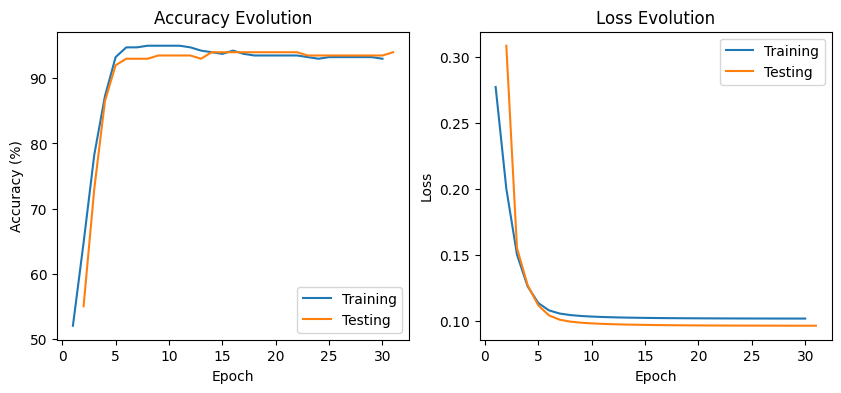

In [6]:
figure, axis = plt.subplots(1, 2, figsize=(10,4))

# Accuracy
axis[0].plot([i+1 for i in range(len(training_accuracy_list))], training_accuracy_list, label='Training')
axis[0].plot([i+2 for i in range(len(testing_accuracy_list))], [i* 100 for i in testing_accuracy_list], label='Testing')
axis[0].set_title('Accuracy Evolution')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Accuracy (%)')
axis[0].legend()
# Loss
axis[1].plot([i+1 for i in range(len(training_accuracy_list))], training_loss_list, label='Training')
axis[1].plot([i+2 for i in range(len(testing_accuracy_list))], testing_loss_list, label='Testing')
axis[1].set_title('Loss Evolution')
axis[1].set_ylabel('Loss')
axis[1].set_xlabel('Epoch')
axis[1].legend()

# Combine all the operations and display
plt.show()